# Problem 2: Incorporating CNNs

* Learning Objective: In this problem, you will learn how to deeply understand how Convolutional Neural Networks work by implementing one.
* Provided Code: We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* TODOs: you will implement a Convolutional Layer and a MaxPooling Layer to improve on your classification results in part 1.

In [ ]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.datasets import *
from lib.mlp.train import *
from lib.cnn.layer_utils import *
from lib.cnn.cnn_models import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Loading the data (SVHN)
Run the following code block to download SVHN dataset and load in the properly splitted SVHN data. The script `get_datasets.sh` use `wget` to download the SVHN dataset. If you have a trouble with executing `get_datasets.sh`, you can manually download the dataset and extract files.

In [ ]:
!./get_datasets.sh
# !get_datasets.sh for windows users

In [ ]:
data = SVHN_data()
for k, v in data.items():
    print ("Name: {} Shape: {}".format(k, v.shape))

Name: data_train Shape: (70000, 32, 32, 3)
Name: labels_train Shape: (70000,)
Name: data_val Shape: (3257, 32, 32, 3)
Name: labels_val Shape: (3257,)
Name: data_test Shape: (26032, 32, 32, 3)
Name: labels_test Shape: (26032,)


## Convolutional Neural Networks

We will use convolutional neural networks to try to improve on the results from Problem 1. Convolutional layers make the assumption that local pixels are more important for prediction than far-away pixels. This allows us to form networks that are robust to small changes in positioning in images.

### Convolutional Layer Output size calculation [2pts]

As you have learned, two important parameters of a convolutional layer are its stride and padding. To warm up, we will need to calculate the output size of a convolutional layer given its stride and padding. To do this, open the `lib/cnn/layer_utils.py` file and fill out the TODO section in the `get_output_size` function in the ConvLayer2D class. 

Implement your function so that it returns the correct size as indicated by the block below.

In [ ]:
%reload_ext autoreload

input_image = np.zeros([32, 28, 28, 3]) # a stack of 32 28 by 28 rgb images

in_channels = input_image.shape[-1] #must agree with the last dimension of the input image
k_size = 4 
n_filt = 16

conv_layer = ConvLayer2D(in_channels, k_size, n_filt, stride=2, padding=3)
output_size = conv_layer.get_output_size(input_image.shape) 

print("Received {} and expected [32, 16, 16, 16]".format(output_size))

Received [32, 16, 16, 16] and expected [32, 16, 16, 16]


### Convolutional Layer Forward Pass [5pts]

Now, we will implement the forward pass of a convolutional layer. Fill in the TODO block in the `forward` function of the ConvLayer2D class.

In [ ]:
%reload_ext autoreload

# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=1*8*8*1).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image
in_channels, k_size, n_filt = 1, 5, 2

weight_size = k_size*k_size*in_channels*n_filt
bias_size = n_filt



single_conv = ConvLayer2D(in_channels, k_size, n_filt, stride=1, padding=0, name="conv_test")

w = np.linspace(-0.2, 0.2, num=weight_size).reshape(k_size, k_size, in_channels, n_filt)
b = np.linspace(-0.3, 0.3, num=bias_size)

single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

out = single_conv.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 4, 4, 2)".format(out.shape))

correct_out = np.array([[
   [[-0.03874312, 0.57000324],
   [-0.03955296, 0.57081309],
   [-0.04036281, 0.57162293],
   [-0.04117266, 0.57243278]],

  [[-0.0452219, 0.57648202],
   [-0.04603175, 0.57729187],
   [-0.04684159, 0.57810172],
   [-0.04765144, 0.57891156]],

  [[-0.05170068, 0.5829608 ],
   [-0.05251053, 0.58377065],
   [-0.05332038, 0.5845805 ],
   [-0.05413022, 0.58539035]],

  [[-0.05817946, 0.58943959],
   [-0.05898931, 0.59024943],
   [-0.05979916, 0.59105928],
   [-0.06060901, 0.59186913]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 4, 4, 2), Expected output shape: (1, 4, 4, 2)
Difference:  5.110565335399418e-08


### Conv Layer Backward [5pts]

Now complete the backward pass of a convolutional layer. Fill in the TODO block in the `backward` function of the ConvLayer2D class. Check you results with this code and expect differences of less than 1e-6.

In [ ]:
%reload_ext autoreload

# Test the conv backward function
img = np.random.randn(15, 8, 8, 3)
w = np.random.randn(4, 4, 3, 12)
b = np.random.randn(12)
dout = np.random.randn(15, 4, 4, 12)

single_conv = ConvLayer2D(input_channels=3, kernel_size=4, number_filters=12, stride=2, padding=1, name="conv_test")
single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

dimg_num = eval_numerical_gradient_array(lambda x: single_conv.forward(img), img, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_conv.forward(img), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_conv.forward(img), b, dout)

out = single_conv.forward(img)

dimg = single_conv.backward(dout)
dw = single_conv.grads[single_conv.w_name]
db = single_conv.grads[single_conv.b_name]

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The errors should be around 1e-8
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  2.3402979441578255e-08
dw Error:  2.547508984587034e-09
db Error:  5.429284799222169e-10
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


## Max pooling Layer
Now we will implement maxpooling layers, which can help to reduce the image size while preserving the overall structure of the image.

### Forward Pass max pooling [5pts]
Fill out the TODO block in the `forward` function of the MaxPoolingLayer class.

In [ ]:
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=64).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")
out = maxpool.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 3, 3, 1)".format(out.shape))

correct_out = np.array([[
   [[0.11428571],
   [0.13015873],
   [0.14603175]],

  [[0.24126984],
   [0.25714286],
   [0.27301587]],

  [[0.36825397],
   [0.38412698],
   [0.4       ]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 3, 3, 1), Expected output shape: (1, 3, 3, 1)
Difference:  1.8750000280978013e-08


### Backward Pass Max pooling [5pts]
Fill out the `backward` function in the MaxPoolingLayer class.

In [ ]:
img = np.random.randn(15, 8, 8, 3)

dout = np.random.randn(15, 3, 3, 3)

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")

dimg_num = eval_numerical_gradient_array(lambda x: maxpool.forward(img), img, dout)

out = maxpool.forward(img)
dimg = maxpool.backward(dout)

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.282400128757547e-12
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


### Test a Small Fully Connected Network [3pts]
Please find the `TestCNN` class in `lib/cnn/cnn_models.py`.
Again you only need to complete few lines of code in the TODO block.
Please design a Convolutional --> Maxpool --> flatten --> fc network where the shapes of parameters match the given shapes.
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively.
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup.

In [ ]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = TestCNN()
loss_func = cross_entropy()

B, H, W, iC = 4, 8, 8, 3 #batch, height, width, in_channels
k = 3 #kernel size
oC, Hi, O = 3, 27, 5 # out channels, Hidden Layer input, Output size
std = 0.02
x = np.random.randn(B,H,W,iC)
y = np.random.randint(O, size=B)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("conv1_w").std() - std)
b1 = model.net.get_params("conv1_b").std()
w2_std = abs(model.net.get_params("fc1_w").std() - std)
b2 = model.net.get_params("fc1_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=k*k*iC*oC).reshape(k,k,iC,oC)
w2 = np.linspace(-0.2, 0.2, num=Hi*O).reshape(Hi, O)
b1 = np.linspace(-0.6, 0.2, num=oC)
b2 = np.linspace(-0.9, 0.1, num=O)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("conv1_w", w1)
model.net.assign("conv1_b", b1)
model.net.assign("fc1_w", w2)
model.net.assign("fc1_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=B*H*W*iC).reshape(B,H,W,iC)
scores = model.forward(feats)
correct_scores = np.asarray([[-13.85107294, -11.52845818,  -9.20584342,  -6.88322866,  -4.5606139 ],
 [-11.44514171, -10.21200524 , -8.97886878 , -7.74573231 , -6.51259584],
 [ -9.03921048,  -8.89555231 , -8.75189413 , -8.60823596,  -8.46457778],
 [ -6.63327925 , -7.57909937 , -8.52491949 , -9.4707396 , -10.41655972]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 2, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 4.56046848799693
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
conv1_b relative error: 3.95e-09
conv1_w relative error: 9.10e-10
fc1_b relative error: 9.76e-11
fc1_w relative error: 3.89e-07


### Training the Network [25pts]
In this section, we defined a `SmallConvolutionalNetwork` class for you to fill in the TODO block in `lib/cnn/cnn_models.py`.

Here please design a network with at most two convolutions and two maxpooling layers (you may use less).
You can adjust the parameters for any layer, and include layers other than those listed above that you have implemented.
You are also free to select any optimizer you have implemented (with any learning rate).

Try to find a combination that is able to achieve 88% validation accuracy.

In [ ]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [ ]:
print("Data shape:", data_dict["data_train"][0].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (70000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 10


In [ ]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
#############################################################################
optimizer = Adam(model.net, 5e-4)

batch_size = 32
epochs = 9
lr_decay = .5
lr_decay_every = 1000

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=100, verbose=True)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

(Iteration 1 / 19683) loss: 2.3023428848991427
(Iteration 101 / 19683) loss: 2.3391931528669536
(Iteration 201 / 19683) loss: 2.201214278641702
(Iteration 301 / 19683) loss: 2.191879327999933
(Iteration 401 / 19683) loss: 1.983087150201709
(Iteration 501 / 19683) loss: 1.7287080976330422
(Iteration 601 / 19683) loss: 0.928436705771141
(Iteration 701 / 19683) loss: 0.6283921500453737
(Iteration 801 / 19683) loss: 0.788084753871011
(Iteration 901 / 19683) loss: 0.9719606415263402
(Iteration 1001 / 19683) loss: 0.7285693532098172
(Iteration 1101 / 19683) loss: 0.6324929317876212
(Iteration 1201 / 19683) loss: 0.6435949970666662
(Iteration 1301 / 19683) loss: 0.48623180398109866
(Iteration 1401 / 19683) loss: 0.7805064745916239
(Iteration 1501 / 19683) loss: 0.612128030612862
(Iteration 1601 / 19683) loss: 0.497270738553827
(Iteration 1701 / 19683) loss: 0.5128987640754546
(Iteration 1801 / 19683) loss: 0.6182506650396202
(Iteration 1901 / 19683) loss: 0.9811210504012211
(Iteration 2001 / 

Run the code below to generate the training plots.

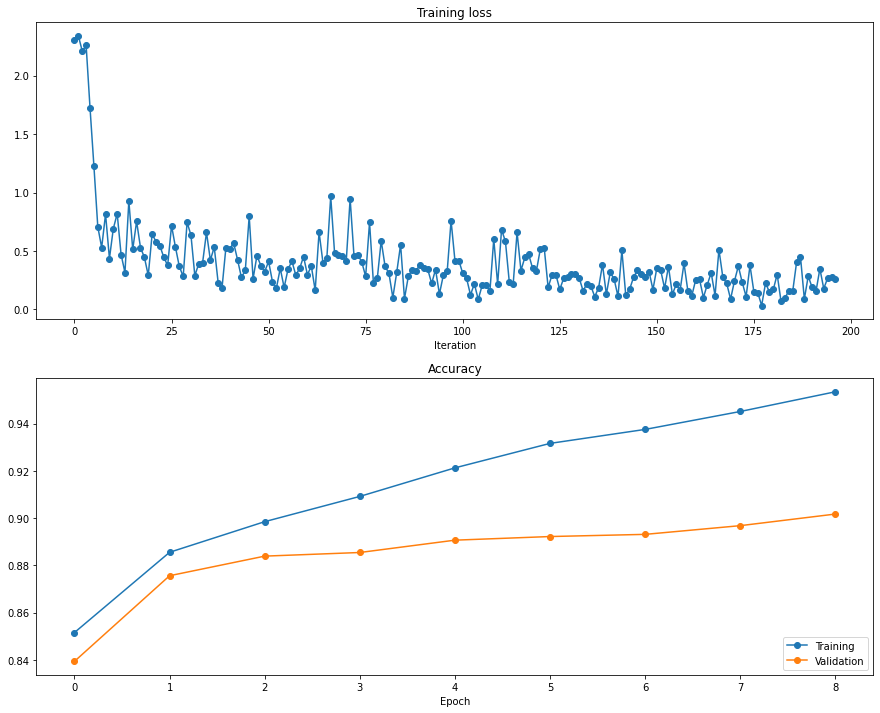

In [ ]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist, val_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

### Visualizing Layers [5pts]

An interesting finding from early research in convolutional networks was that the learned convolutions resembled filters used for things like edge detection. Complete the code below to visualize the filters in the first convolutional layer of your best model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


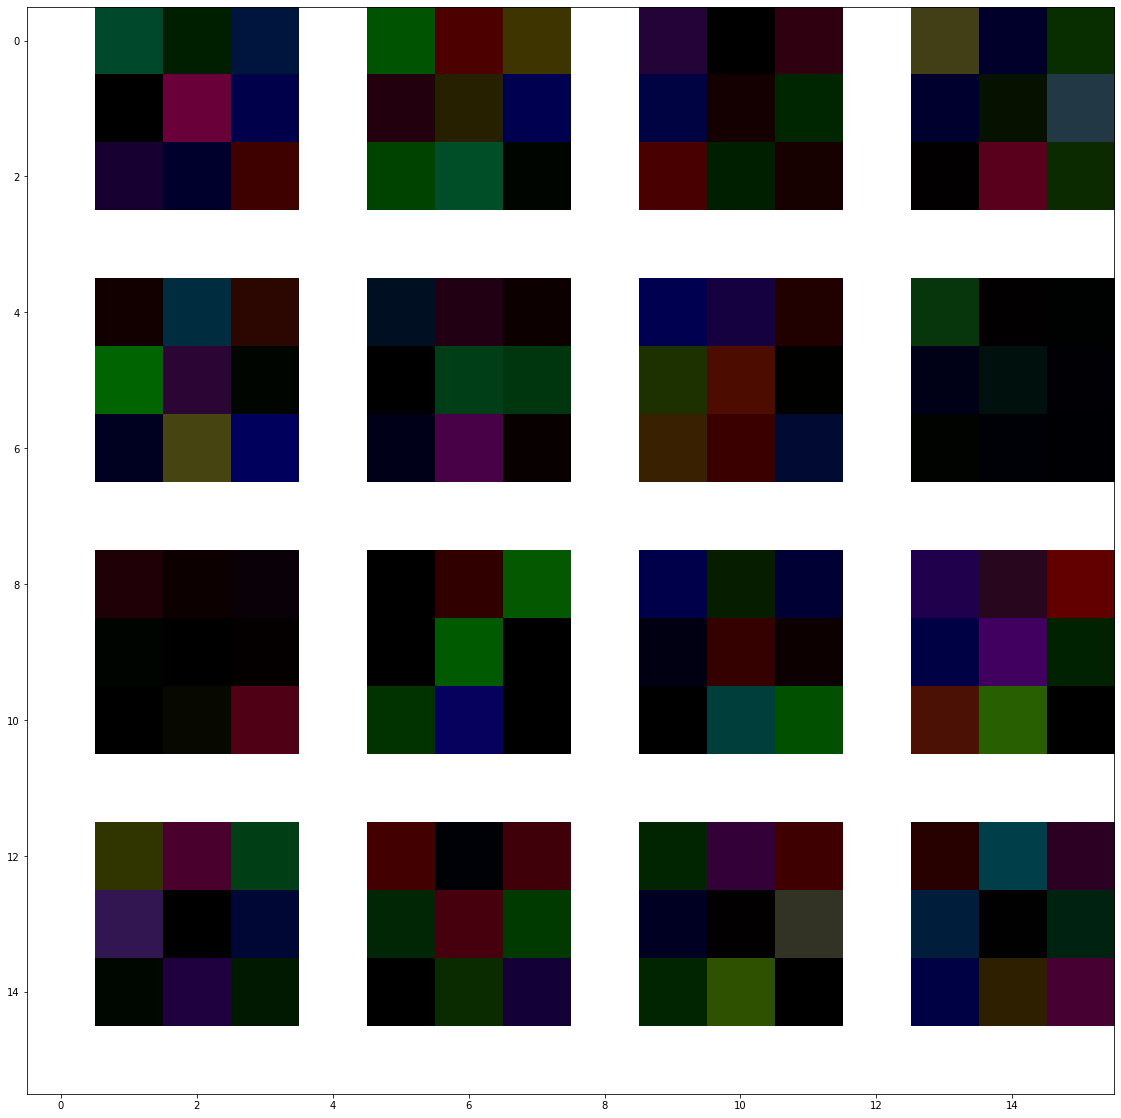

In [ ]:
im_array = None
nrows, ncols = None, None

###################################################
# TODO: read the weights in the convolutional     #
# layer and reshape them to a grid of images to   #
# view with matplotlib.                           #
###################################################
filters = model.net.get_params("conv1_w")
nrows, ncols = filters.shape[-1] // 4, 4 
h,w,c,n = filters.shape
filters = filters.reshape(n,h,w,c)
a = np.ones((n,1,w,c))
x = np.concatenate((filters,a),axis=1)
a = np.ones((n,x.shape[1],1,c))
x = np.concatenate((a,x),axis=2)
n,h,w,c = x.shape
im_array = x.reshape(nrows,ncols,h,w,c).swapaxes(1,2).reshape(h*nrows, w*ncols,c)
plt.figure(figsize=(20,20))
###################################################
#                END OF YOUR CODE                 #
###################################################

plt.imshow(im_array)

#### Inline Question: Comment below on what kinds of filters you see. Include your response in your submission [5pts]

The filters are mostly edge detection filters. Some of the filters might be trying to detect areas or edges in the corners, like top-left or bottom-right. Some are detecting the vertical as well as the diagonal edges in the input image, while the others may be attempting to identify edges or patches in any particular point of the image, like the center of the image. Moreover, I think there are some filters which are trying to learn some patterns pertaining to some digits, like a pattern resembling a portion of a particular digit.

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for CNN training
2. Visualization of convolutional filters
3. Answers to inline questions about convolutional filters

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.